In [10]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
house_prices <- source('main.R', local = TRUE)$value

combined_dataset <-
    house_prices$helpers$load_data() %>%
    (house_prices$outliers$remove_outliers) %>%
    (house_prices$missing$fix_all) %>%
    select(-Id)

test_that("should be no NA values except SalePrice column", {
    expect_equal(sum(is.na(combined_dataset %>% select(-SalePrice))), 0)
})

In [17]:
house_prices <- source('main.R', local = TRUE)$value

transFn <- tribble(
    ~tran_name, ~tran_fn,
    'log',      function(x) log(x+1),
    'sqrt',     function(x) sqrt(x),
    'inv3',     function(x) x**(1/3),
    'inv4',     function(x) x**(1/4)
)

transformation_config <- 
    house_prices$trans$numeric$Tran$get_transformation_config(
        dataset=combined_dataset %>% select_if(is.numeric),
        trans=transFn
    )
        
transformation_config2 <- 
    house_prices$trans$numeric$Tran$get_transformation_config(
        dataset=combined_dataset,
        trans=transFn
    )
        
test_that("should be equal", {
    expect_equal(
        transformation_config %>% select(-tran_fn), 
        transformation_config2 %>% select(-tran_fn)
    )
})

transformation_config

var,tran_name,progress_score,tran_fn
SalePrice,log,91.29808588,"function (x) , log(x + 1)"
GrLivArea,log,91.15794157,"function (x) , log(x + 1)"
X1stFlrSF,log,90.77165686,"function (x) , log(x + 1)"
BsmtUnfSF,sqrt,79.97603070,"function (x) , sqrt(x)"
LotArea,inv4,78.86402649,"function (x) , x^(1/4)"
TotRmsAbvGrd,log,30.68501506,"function (x) , log(x + 1)"
OverallQual,log,29.94435652,"function (x) , log(x + 1)"
GarageCars,log,24.95676474,"function (x) , log(x + 1)"
BedroomAbvGr,log,22.37508601,"function (x) , log(x + 1)"
OverallCond,log,16.24723935,"function (x) , log(x + 1)"


In [93]:
train <-
    combined_dataset %>%
    select(transformation_config$var) %>%
    filter(!is.na(SalePrice)) %>%
    mutate(price_log = log(SalePrice))

transformation_config %>%
mutate(
    r2_x = map_dbl(var, function(var) {
        data <- 
            train %>% 
            select(c(var, "price_log"))
        model = lm(as.formula(paste0("price_log ~ ", var)), data=train)
        summary(model)$r.squared
    }),
    r2_tran = map2_dbl(var, tran_fn, function(var, tran_fn) {
        data <- 
            train %>% 
            select(c(var, "price_log"))
        data[var] <- tran_fn(data[var])
        model = lm(as.formula(paste0("price_log ~ ", var)), data=data)
        summary(model)$r.squared
    })
) %>%
filter(r2_tran > r2_x)

var,tran_name,progress_score,tran_fn,r2_x,r2_tran
SalePrice,log,91.298086,"function (x) , log(x + 1)",0.89945291,1.0000000
GrLivArea,log,91.157942,"function (x) , log(x + 1)",0.52593095,0.5438044
LotArea,inv4,78.864026,"function (x) , x^(1/4)",0.06788313,0.1591873
TotRmsAbvGrd,log,30.685015,"function (x) , log(x + 1)",0.28912299,0.2938676
Fireplaces,inv4,3.801495,"function (x) , x^(1/4)",0.24206172,0.2651322


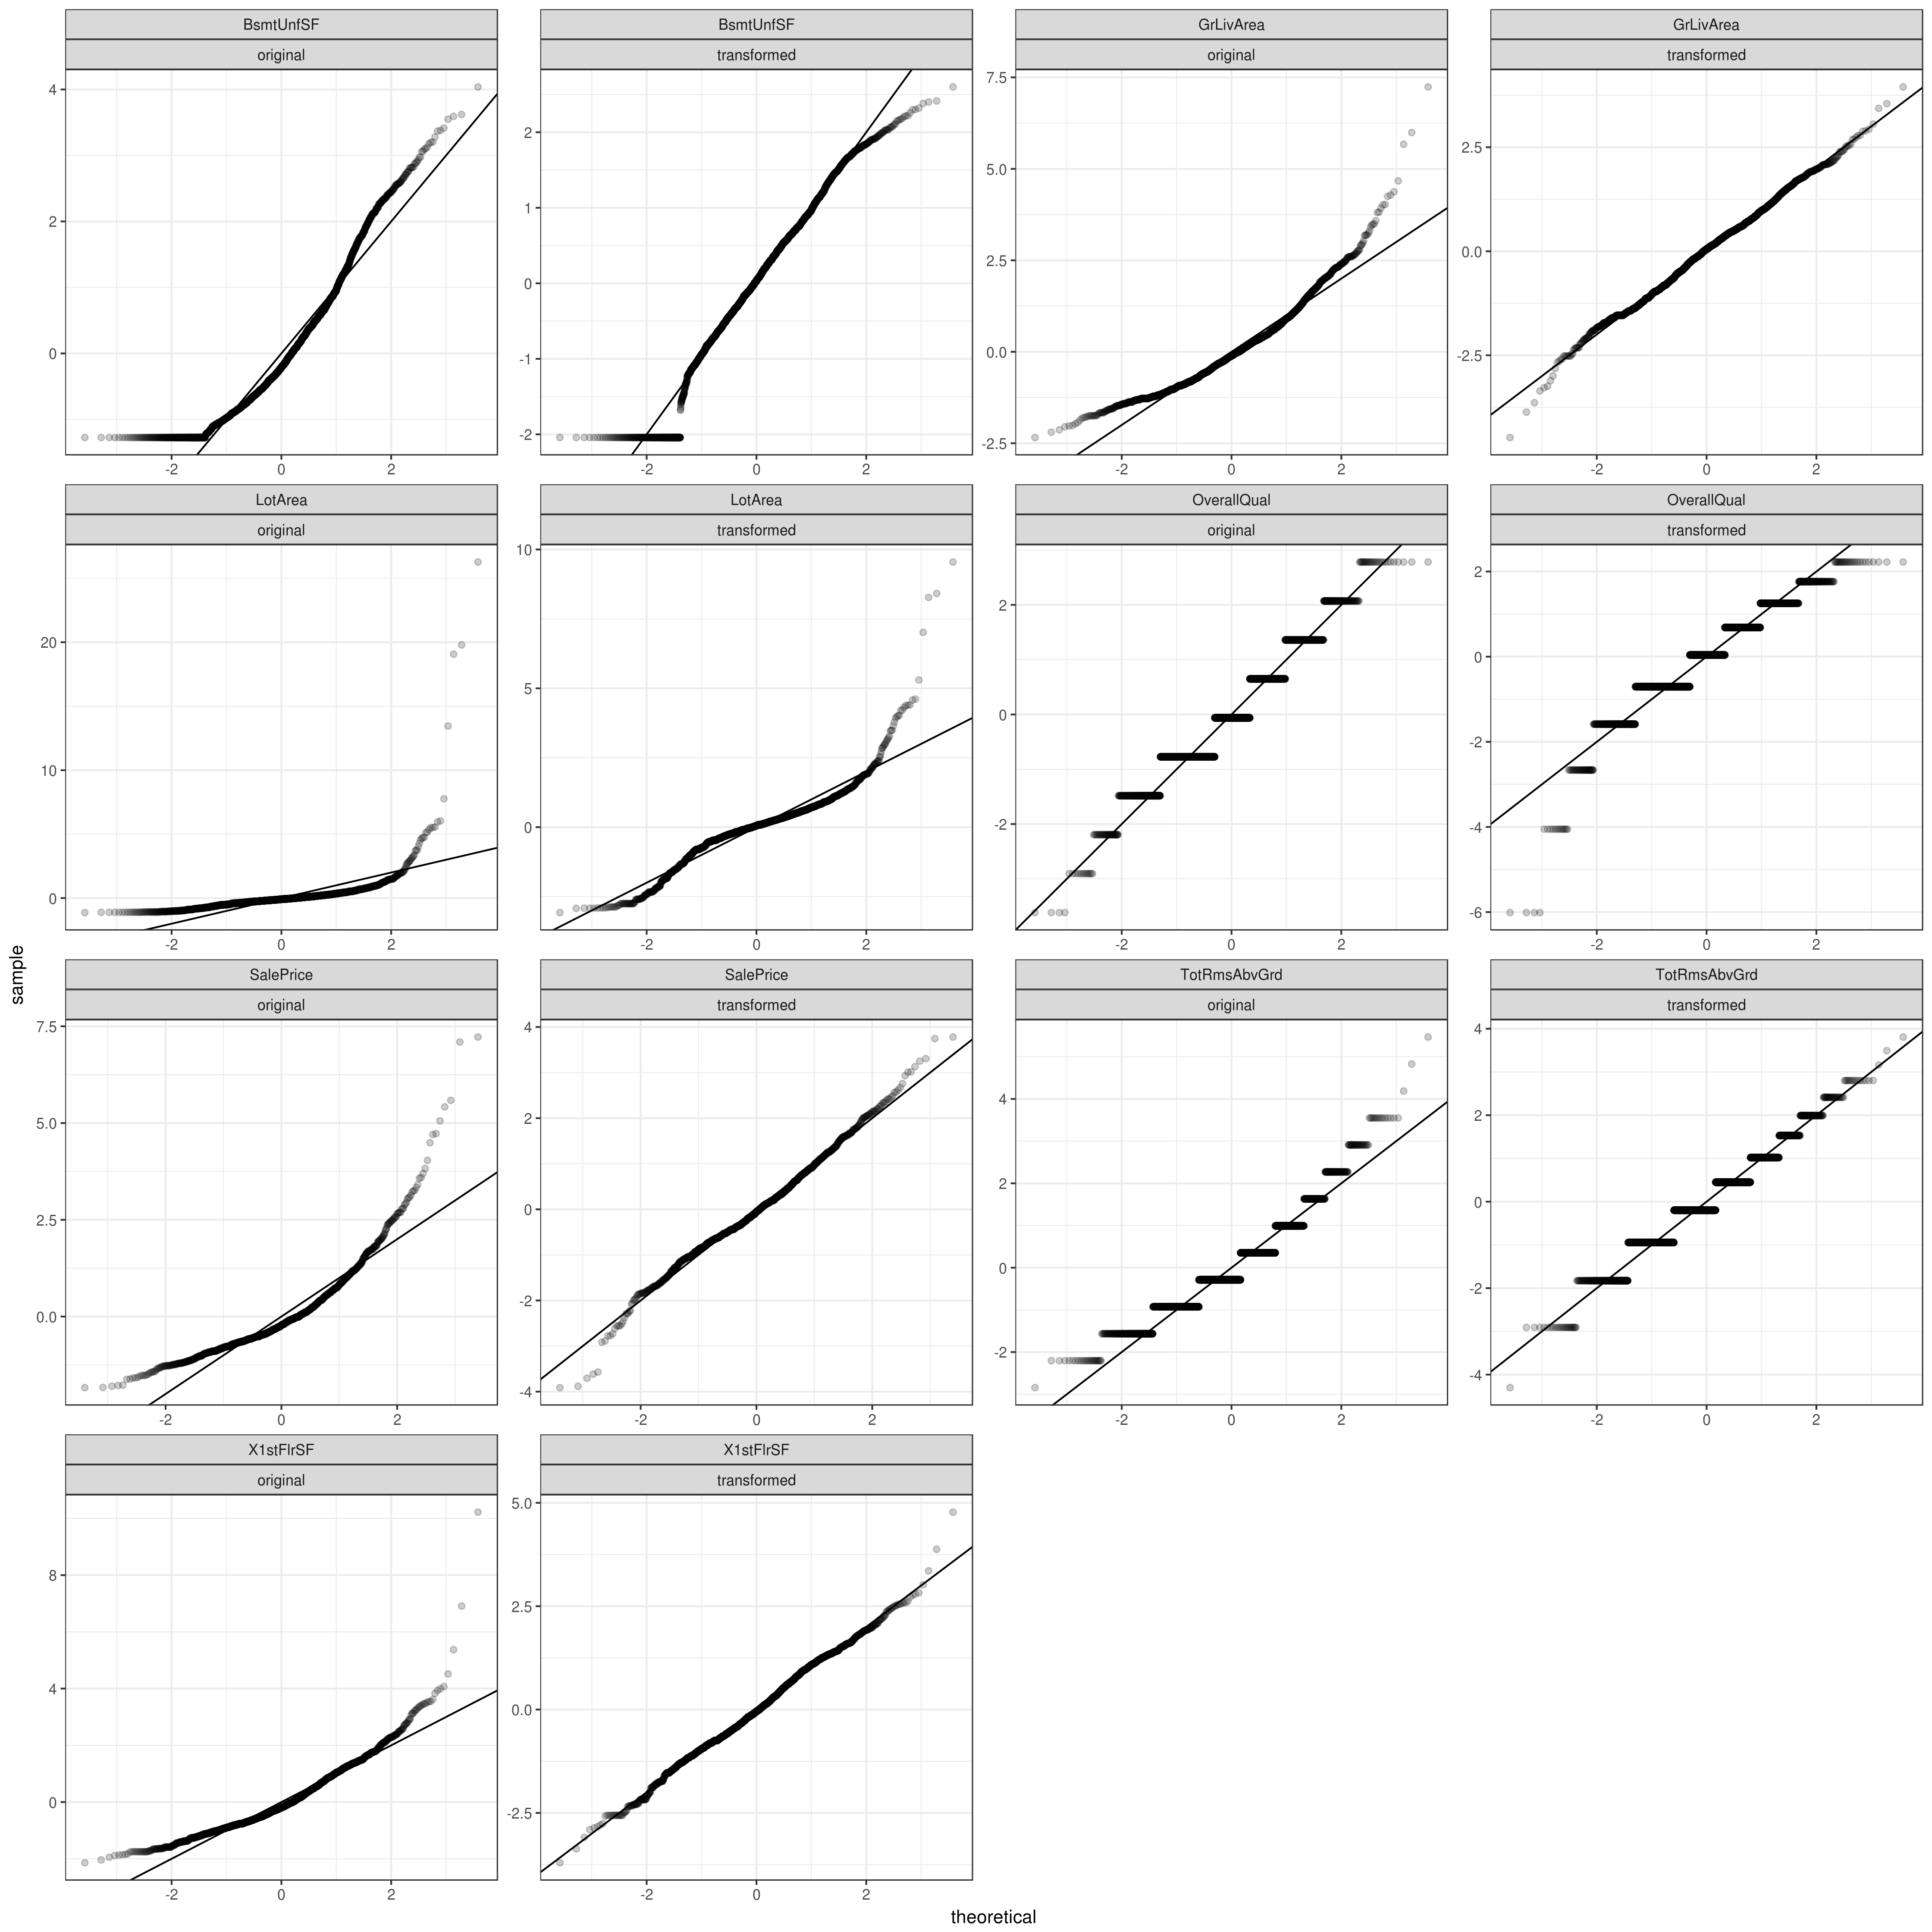

In [22]:
df <- house_prices$trans$numeric$Tran$for_qq_plot(
    combined_dataset, 
    transformation_config %>% filter(progress_score > 25)
)

options(repr.plot.width = 16, repr.plot.height = 16, repr.plot.res=280)

df %>%
ggplot() +
geom_qq(aes(sample=normed_value), alpha=0.2) +
facet_wrap(var~tran, ncol=4, scales="free") +
geom_abline(slope=1) +
theme_bw()

In [30]:
trainset <- 
    combined_dataset %>% 
    select(OverallQual, SalePrice) %>% 
    filter(!is.na(SalePrice)) %>%
    mutate(
        price_log = log(SalePrice),
        qual_log = log(OverallQual + 1)
    )

mod1 <- lm(price_log ~ qual_log, data=trainset)
mod1 %>% glance

mod2 <- lm(price_log ~ OverallQual, data=trainset)
mod2 %>% glance

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.6475234,0.6472813,0.2373915,2674.77,0,2,28.85732,-51.71464,-35.86017,82.05248,1456


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.6747053,0.6744819,0.2280544,3019.942,0,2,87.3617,-168.7234,-152.8689,75.72483,1456


In [58]:
trans <- transFn

df <-
    combined_dataset %>%
    filter(!is.na(SalePrice)) %>%
    mutate(price_log = log(SalePrice)) %>%
    select(-SalePrice) %>%
    select_if(is.numeric) %>%
    gather(var, x, -price_log) %>%
    filter(!is.na(x))

for (row in 1:nrow(trans)) {
    tran_name <- trans[[row, "tran_name"]]
    tran_fn <- trans[[row, 'tran_fn']]
    df[tran_name] <- tran_fn(df$x)
}

x <- 
    df %>%
    group_by(var) %>%
    nest %>%
    mutate(
        qq = map(data, function(data) {
            data %>%
            gather(tran, val, -price_log) %>%
            group_by(tran) %>%
            nest %>%
            mutate(
                r2 = map_dbl(data, function(data) {
                    model = lm(price_log ~ val, data=data)
                    summary(model)$r.squared
                })
            ) %>%
            select(-data)
        })
    ) %>%
    select(-data) %>%
    unnest

In [75]:
x %>% group_by(var) %>%
nest %>%
mutate(
    best_tran = map(data, function(df) {
        best <- df %>% arrange(desc(r2)) %>% head(1)
        vanilla <- df %>% filter(tran == 'x')
        progress_score <- 100 * (best$r2 - vanilla$r2) / vanilla$r2
        data_frame(
            tran_name = best$tran, 
            progress_score = progress_score,
            r2_vanilla = vanilla$r2,
            r2_best = best$r2
        )
    })
) %>%
select(-data) %>%
unnest %>%
filter(tran_name != 'x') %>%
inner_join(trans, by=c("tran_name")) %>%
arrange(desc(progress_score)) %>%
filter(r2_best > 0.02)

var,tran_name,progress_score,r2_vanilla,r2_best,tran_fn
LotArea,log,139.0342258,0.06788313,0.16226391,"function (x) , log(x + 1)"
OpenPorchSF,log,100.6086565,0.10576491,0.21217356,"function (x) , log(x + 1)"
EnclosedPorch,log,93.3934765,0.02220976,0.04295222,"function (x) , log(x + 1)"
WoodDeckSF,sqrt,12.4949152,0.11172336,0.12568310,"function (x) , sqrt(x)"
Fireplaces,inv3,9.7205990,0.24206172,0.26559157,"function (x) , x^(1/3)"
HalfBath,inv4,7.8924221,0.09871256,0.10650337,"function (x) , x^(1/4)"
MasVnrArea,sqrt,5.5471235,0.18539004,0.19567385,"function (x) , sqrt(x)"
GrLivArea,inv4,3.5324316,0.52593095,0.54450911,"function (x) , x^(1/4)"
BsmtFullBath,inv3,2.3301272,0.05621609,0.05752600,"function (x) , x^(1/3)"
TotRmsAbvGrd,inv3,1.7474474,0.28912299,0.29417526,"function (x) , x^(1/3)"


In [73]:
trainset <- 
    combined_dataset %>% 
    select(MiscVal, SalePrice) %>% 
    filter(!is.na(SalePrice)) %>%
    mutate(
        price_log = log(SalePrice),
        misc_log = log(MiscVal + 1)
    )

mod1 <- lm(price_log ~ misc_log, data=trainset)
mod1 %>% glance

mod2 <- lm(price_log ~ MiscVal, data=trainset)
mod2 %>% glance

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.004493942,0.003810215,0.3989532,6.572717,0.01045502,2,-728.0392,1462.078,1477.933,231.7423,1456


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.0004004872,-0.0002860509,0.3997726,0.583343,0.4451287,2,-731.0307,1468.061,1483.916,232.6952,1456


In [42]:
transformation_config <- house_prices$trans$numeric$Tran$get_transformation_config(
    dataset=combinedDatasetNumeric,
    trans=transFn
) %>% 
filter(progress_score > 30)

transformed_numeric <-
    house_prices$trans$numeric$Tran$apply_transform(combinedDatasetNumeric, transformation_config)


test_that("should be equal", {
    expect_equal(
        transformed_numeric %>% select(-one_of(transformation_config$var)), 
        combinedDatasetNumeric %>% select(-one_of(transformation_config$var))
    )
})

test_that("GrLivArea", {
    expect_equal(
        transformed_numeric$GrLivArea, 
        log(combined_dataset$GrLivArea + 1)
    )
})

test_that("BsmtUnfSF", {
    expect_equal(
        transformed_numeric$BsmtUnfSF, 
        sqrt(combined_dataset$BsmtUnfSF)
    )
})

test_that("LotArea", {
    expect_equal(
        transformed_numeric$LotArea, 
        (combined_dataset$LotArea)**(1/4)
    )
})

In [46]:
house_prices <- source('main.R', local = TRUE)$value

tran_config <- 
    house_prices$trans$numeric$Tran$get_transformation_config(
        dataset=combinedDatasetNumeric,
        trans=transFn
    ) %>% filter(progress_score > 30)


transformed_combined <-
    house_prices$trans$numeric$functional_transform(
        data = combined_dataset, 
        trans = transFn, 
        threshold = 30
    )

test_that("should be equal", {
    expect_equal(
        transformed_numeric, 
        transformed_combined %>% select_if(is.numeric) %>% select(-SalePrice)
    )
})

test_that("should be equal", {
    expect_equal(
        combined_dataset %>% select(-one_of(tran_config$var)), 
        transformed_combined %>% select(-one_of(tran_config$var))
    )
})